In [10]:
!pip install torchsummary

In [11]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np
import pandas as pd
import torch
from torch.nn import Module
from torch.nn import Sequential
from torch.nn import Conv2d
from torch.nn import Linear
from torch.nn import MaxPool2d
from torch.nn import AvgPool2d
from torch.nn import BatchNorm2d
from torch.nn import ReLU
from torch.nn import Sigmoid
from torch.nn import Tanh
from torch.nn import ELU
from torch.nn import LogSoftmax
from torch.nn import Dropout
from torch.utils.data import DataLoader
import torch.nn as nn
from torch import flatten

from sklearn.metrics import accuracy_score, f1_score
from torchvision import datasets
from torchvision import transforms
from torchvision.transforms.autoaugment import AutoAugmentPolicy
from torch.utils.data.sampler import SubsetRandomSampler
from datasets import load_dataset
from sklearn.model_selection import train_test_split
from tqdm.notebook import tqdm

import torch.optim as optim
from torch.utils.data import DataLoader
from torch.utils.data import Dataset
from torchvision.transforms import ToTensor
from torchsummary import summary
import cv2
import glob
import pickle
import matplotlib.pyplot as plt


device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/cifar10-python/cifar-10-python.tar.gz
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_1
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_2
/kaggle/input/cifar10-python/cifar-10-batches-py/batches.meta
/kaggle/input/cifar10-python/cifar-10-batches-py/test_batch
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_3
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_5
/kaggle/input/cifar10-python/cifar-10-batches-py/data_batch_4
/kaggle/input/cifar10-python/cifar-10-batches-py/readme.html


# Dataset Processing

In [12]:
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

folder_path="/kaggle/input/cifar10-python/cifar-10-batches-py"

file_paths = glob.glob(folder_path + '/data_batch_*')

dicts=[]
for file_path in file_paths:
    # Do something with the file, for example, print its path
    dicts.append(unpickle(file_path))

images=[]
allLabels=[]
for d in dicts:
    keys_list = list(d.keys())

    labels=d[keys_list[1]]
    img_data=d[keys_list[2]]

    red_channel = img_data[:, :1024].reshape(10000, 32, 32)
    green_channel = img_data[:, 1024:2048].reshape(10000, 32, 32)
    blue_channel = img_data[:, 2048:].reshape(10000, 32, 32)

    image_array = np.stack((red_channel, green_channel, blue_channel), axis=-1)
    images.append(image_array)
    allLabels.append(labels)



In [13]:
def CIFARDataset(images,labels):
    newPath = './CIFAR_DataSet'

    os.makedirs(newPath, exist_ok=True)

    uniquelabels=np.unique(labels)
    mp={}

    for label in uniquelabels:
        rdpath=newPath+"/"+str(label)

        os.makedirs(rdpath, exist_ok=True)

        mp[label]=1

    for i in range(len(labels)):
        for j in range(len(labels[i])):

            img=images[i][j]
            img=img.astype(np.uint8)
            lab=labels[i][j]

            wrtPath=newPath+'/'+ str(lab) +'/'+str(mp[lab]) + '.jpg'
            
            cv2.imwrite(wrtPath,img)
            mp[lab]+=1
        
# CIFARDataset(images,allLabels)

In [14]:
def loadDataset():
    imgs = []
    labels = []
    label = -1
    rdir_path = '/kaggle/working/CIFAR_DataSet'

    dirs = [f for f in os.listdir(rdir_path) if os.path.isdir(os.path.join(rdir_path, f))]
    
    for directory in dirs:
        label = label + 1
        path = rdir_path+'/'+directory
        onlyfiles = [f for f in os.listdir(path) if os.path.isfile(os.path.join(path, f))]
        
        for file in onlyfiles:
            imgPath = path+'/'+file
            imgs.append(imgPath)
            labels.append(label)
    # print(imgs[0:100],labels[0:100])
    return (imgs,labels)

In [15]:
# dataset = loadDataset()
# trainImgPaths,testImgPaths, trainLabels, testLabels = train_test_split(dataset[0], dataset[1], train_size=0.8, random_state=42,shuffle = True,stratify = dataset[1])

In [16]:
training_data = datasets.CIFAR10(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)

test_data = datasets.CIFAR10(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

100%|██████████| 170498071/170498071 [00:03<00:00, 56026382.10it/s]


Extracting data/cifar-10-python.tar.gz to data
Files already downloaded and verified


In [17]:
train_loader = DataLoader(training_data, batch_size=64, shuffle=True)
train_loader

# Model

In [18]:
class CNN(Module):
  def __init__(self, in_channels, classes):
    super(CNN, self).__init__()

    self.classes = classes

    self.conv_block_1 = Sequential(
        Conv2d(in_channels = in_channels, out_channels = 64,
               kernel_size = (3, 3), stride = (1, 1), padding = (2, 2)),
        BatchNorm2d(64),
        Sigmoid(),
        Conv2d(in_channels = 64, out_channels = 128,
               kernel_size = (3, 3), stride = (1, 1), padding = (2, 2)),
        BatchNorm2d(128),
        Sigmoid(),
        MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
    )

    self.conv_block_2 = Sequential(
        Conv2d(in_channels = 128, out_channels = 256,
               kernel_size = (3, 3), stride = (1, 1), padding = (1, 1)),
        BatchNorm2d(256),
        Sigmoid(),
        Conv2d(in_channels = 256, out_channels = 256,
               kernel_size = (3, 3), stride = (2, 2), padding = (1, 1)),
        BatchNorm2d(256),
        Sigmoid(),
        MaxPool2d(kernel_size = (2, 2), stride = (2, 2))
    )
 
    self.fc_block = Sequential(
        Linear(in_features = 4 * 4 * 256, out_features = 2048),
        Sigmoid(),
        Dropout(0.3),
        Linear(in_features = 2048, out_features = 512),
        Sigmoid(),
        Dropout(0.3),
        Linear(in_features = 512, out_features = self.classes)
    )




  def forward(self, x):
    x = self.conv_block_1(x)
    x = self.conv_block_2(x)
    x = flatten(x, 1)
    x = self.fc_block(x)
    
#     out = LogSoftmax(x)

    return x



In [19]:
num_classes = 10

model = CNN(3, num_classes).to(device)
summary(model, (3, 32, 32))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 34, 34]           1,792
       BatchNorm2d-2           [-1, 64, 34, 34]             128
           Sigmoid-3           [-1, 64, 34, 34]               0
            Conv2d-4          [-1, 128, 36, 36]          73,856
       BatchNorm2d-5          [-1, 128, 36, 36]             256
           Sigmoid-6          [-1, 128, 36, 36]               0
         MaxPool2d-7          [-1, 128, 18, 18]               0
            Conv2d-8          [-1, 256, 18, 18]         295,168
       BatchNorm2d-9          [-1, 256, 18, 18]             512
          Sigmoid-10          [-1, 256, 18, 18]               0
           Conv2d-11            [-1, 256, 9, 9]         590,080
      BatchNorm2d-12            [-1, 256, 9, 9]             512
          Sigmoid-13            [-1, 256, 9, 9]               0
        MaxPool2d-14            [-1, 25

In [28]:
num_epochs = 10
learning_rate=0.001
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=learning_rate)

In [29]:
epoch_losses = []

for epoch in range(num_epochs):
    model.train()
    running_loss = 0.0
    with tqdm(train_loader, unit="batch") as tepoch:
        tepoch.set_description(f"Epoch {epoch+1}/{num_epochs}")
        for images, labels in tepoch:
            images, labels = images.to(device), labels.to(device)
            
            # Zero the parameter gradients
            optimizer.zero_grad()

            # Forward pass
            outputs = model(images)
            loss = criterion(outputs, labels)

            # Backward pass and optimization
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * images.size(0)
            tepoch.set_postfix(loss=running_loss / ((tepoch.n + 1) * train_loader.batch_size))

    # Print statistics
    epoch_loss = running_loss / len(training_data)
    epoch_losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.4f}')

  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [1/10], Loss: 0.4589


  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [2/10], Loss: 0.4358


  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [3/10], Loss: 0.4103


  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [4/10], Loss: 0.3898


  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [5/10], Loss: 0.3788


  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [6/10], Loss: 0.3486


  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [7/10], Loss: 0.3308


  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [8/10], Loss: 0.3041


  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [9/10], Loss: 0.2900


  0%|          | 0/782 [00:00<?, ?batch/s]

Epoch [10/10], Loss: 0.2719


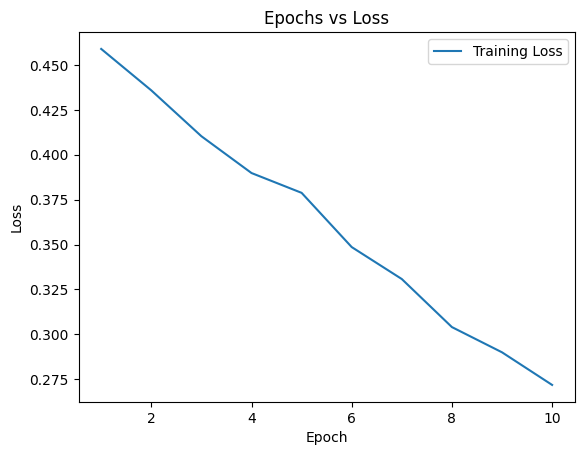

In [30]:
plt.plot(range(1, num_epochs+1), epoch_losses, label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Epochs vs Loss')
plt.legend()
plt.savefig("Adam_ReLU4444.png")
plt.show()

In [31]:
loss_fn = torch.nn.CrossEntropyLoss()

def validate(model, dataloader, sanity_check=False):
    model.eval()
    total_loss = 0
    predictions = []
    truths = []
    
    device = next(model.parameters()).device  # Get the device of the model's parameters
    
    with torch.no_grad():
        for batch in tqdm(dataloader):
            x, y = batch[0].to(device), batch[1].to(device)  # Move input data to the same device as model
            
            output = model(x)
            output = nn.Softmax(dim=-1)(output)
            loss = loss_fn(output, y)
            total_loss += loss.detach().cpu().item() / len(dataloader)
            
            preds = torch.argmax(output, dim=-1)
            predictions.extend(preds.cpu())
            truths.extend(y.cpu())
        
    acc = accuracy_score(y_true=truths, y_pred=predictions)
    f1 = f1_score(y_true=truths, y_pred=predictions, average='macro')
    
    return total_loss, acc, f1, predictions


In [24]:
test_loader = DataLoader(test_data, batch_size=32, shuffle=True)
test_loader

In [32]:
scores = validate(model,test_loader)
print(f"| Test Loss: {scores[0]: 7.3f}  | Test acc: {scores[1]: 1.5f}  | Test f1: {scores[2]: 1.5f}  |")

  0%|          | 0/313 [00:00<?, ?it/s]

| Test Loss:   1.768  | Test acc:  0.70460  | Test f1:  0.71014  |


In [26]:
model_scripted = torch.jit.script(model) # Export to TorchScript
model_scripted.save('neuralNetwork3.pt')

In [27]:
# Loading Model
# model = torch.jit.load('neuralNetwork.pt')
# model.eval()